# Gesture Recognition

In [45]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import skimage
import datetime
import os
import pandas as pd
from matplotlib import pyplot as plt
from skimage.util import random_noise
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid
import pylab as pl
from skimage.filters import gaussian
from scipy.ndimage import zoom
import math
from PIL import Image, ImageFilter, ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D, TimeDistributed, GlobalMaxPool2D, MaxPool2D, ConvLSTM2D, GlobalAveragePooling2D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


We set the random seed so that the results don't vary much.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import math

**data path: /home/datasets/Project_data**

In [5]:
train_path = '/home/datasets/Project_data/train/'
val_path = '/home/datasets/Project_data/val/'
def fetch_data(abalition = False):
    if not abalition:
        train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
        val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
    else:
        train_doc = np.random.choice(open('/home/datasets/Project_data/train.csv').readlines(), abalition)
        val_doc = np.random.choice(open('/home/datasets/Project_data/val.csv').readlines(), abalition)
    
    return train_doc, val_doc
          

In [6]:
train  = pd.read_csv('/home/datasets/Project_data/train.csv', sep=';', header=None)
val  = pd.read_csv('/home/datasets/Project_data/val.csv', sep=';', header = None)

In [7]:
train.sample(3)

0                1  2
152  WIN_20180926_16_54_08_Pro_Right_Swipe_new  Right_Swipe_new  1
314  WIN_20180925_18_02_58_Pro_Thumbs_Down_new  Thumbs_Down_new  3
12    WIN_20180925_17_33_08_Pro_Left_Swipe_new   Left_Swipe_new  0

In [8]:
train.shape

(663, 3)

In [46]:
val.sample(3)

0                1  2
22  WIN_20180926_17_33_14_Pro_Right_Swipe_new  Right_Swipe_new  1
70  WIN_20180907_15_55_06_Pro_Right Swipe_new  Right Swipe_new  1
67  WIN_20180907_15_30_06_Pro_Right Swipe_new  Right Swipe_new  1

### Initial EDA
- Understanding class distribution

In [48]:
train[2].value_counts()

3    137
1    137
0    136
2    130
4    123
Name: 2, dtype: int64

In [49]:
val[2].value_counts()

1    23
2    22
3    21
0    18
4    16
Name: 2, dtype: int64

#### Although the data per class is quite less, they look decently balanced

In [9]:
img_h, img_w = 128, 128 # image dims
img_idx_to_select = range(0,30,2) # frames to select from sequences
batch_size = 64

#### Generator without Augmentation 

In [10]:
def generator(source_path, folder_list, batch_size, debug = False): # generator w/o augmentations
    img_idx = img_idx_to_select
    x = len(img_idx)
    y, z = img_h, img_w
    while True:
        t = np.random.permutation(folder_list)

        num_batches = math.ceil(len(t)/batch_size)
        remaining = len(t)%batch_size
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) 
            for folder in range(batch_size): 
                folder_index = folder + (batch*batch_size) 
                if folder_index >= len(t): #handling leftout sequences from the last yield.
                    break
                folder_str = t[folder_index]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) 
                if debug:
                    plt.figure(figsize=(20,5))
                    print(folder_str.strip().split(';')[1])
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item])
                    image = resize(image, (y, z))
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels 
            

In [14]:
def setup_data(): # helper function to quickly setup data for training
    global train_generator, val_generator, steps_per_epoch, validation_steps
    
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    

#### Testing generator

In [25]:
train_doc, val_doc = fetch_data(abalition=5)

In [26]:
train_doc

array(['WIN_20180926_17_22_54_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_15_56_38_Pro_Right Swipe_new;Right Swipe_new;1\n',
       'WIN_20180907_15_49_02_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n',
       'WIN_20180907_16_02_07_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180907_16_53_36_Pro_Thumbs Down_new;Thumbs Down_new;3\n'],
      dtype='<U88')

In [35]:
gen = generator(train_path, train_doc, 2, debug = True)

Left Swipe_new_Left Swipe_new
Stop Gesture_new


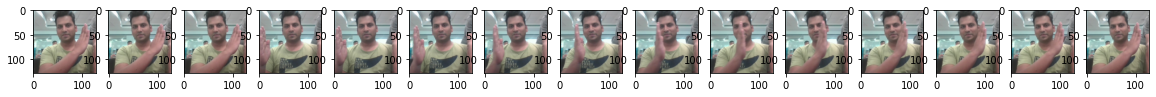

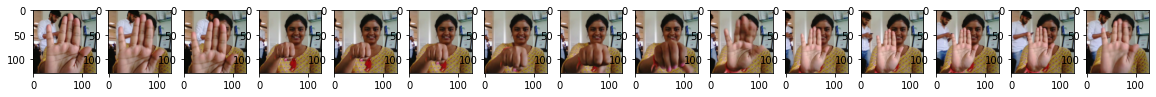

In [36]:
d, l = next(gen)

Thumbs_Up_new
Right_Swipe_new


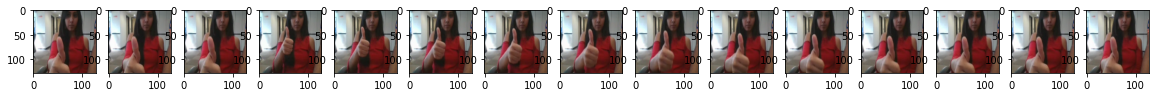

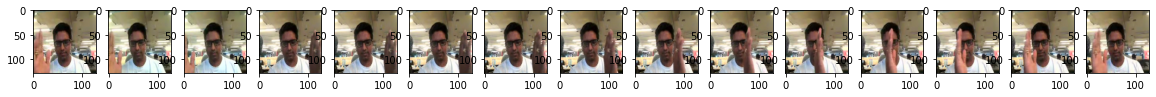

In [835]:
d, l = next(gen)

Thumbs Up_new


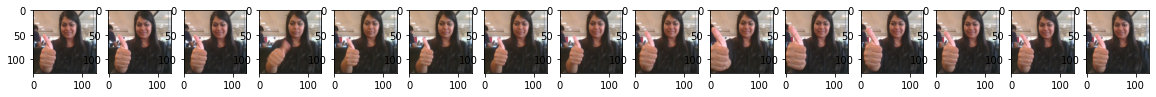

In [836]:
d, l = next(gen)

### Exploring Augmentation Techniques

In [ ]:
# !ls /home/datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/

In [6]:
sample_img = imread('/home/datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00056.png')


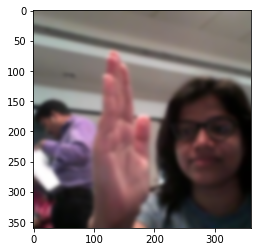

In [66]:
plt.imshow(gaussian(sample_img, 3))

#### Random noise

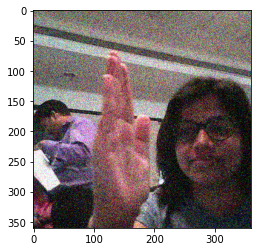

In [77]:
plt.imshow(random_noise(sample_img, var=0.025))

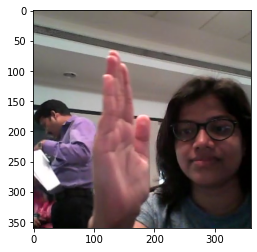

In [8]:
plt.imshow(sample_img)

/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


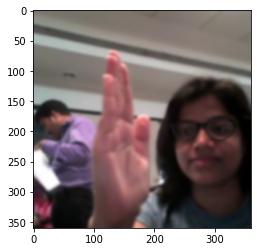

In [9]:
plt.imshow(skimage.filters.gaussian(sample_img, sigma=2))

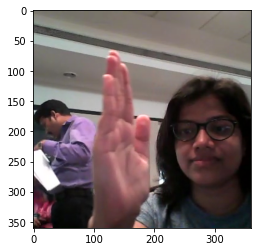

In [10]:
plt.imshow(skimage.exposure.adjust_gamma(sample_img, 1))

In [11]:
highB = sample_img + (100/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


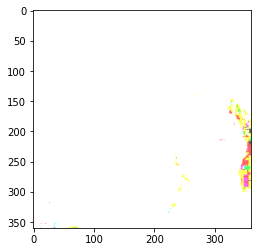

In [12]:
plt.imshow(highB)

/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


ALERT -- picking random var
ALERT -- picking random var
ALERT -- picking random var


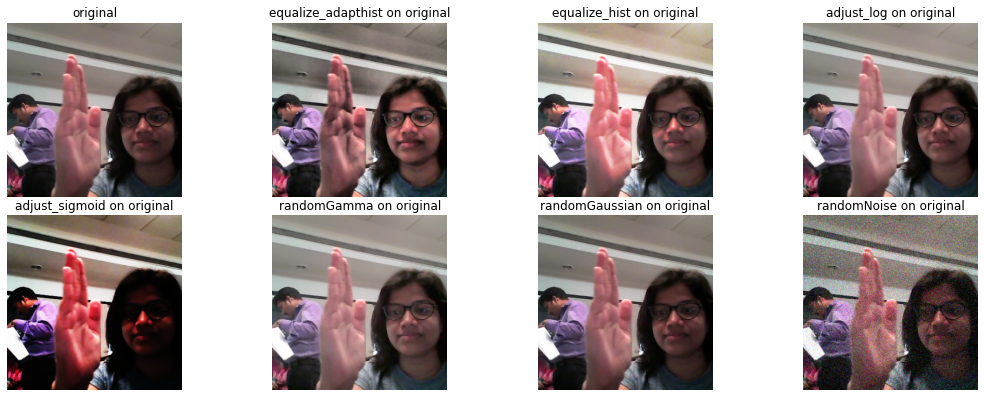

In [89]:
F = pl.figure(figsize=(15,6))
G = pl.GridSpec(2, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, hspace=0.1, figure=F)
ax = pl.subplot(G[0])
ax.imshow(sample_img)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('original')
for i, filt in enumerate([equalize_adapthist, equalize_hist, adjust_log, adjust_sigmoid, randomGamma, randomGaussian, randomNoise]):
    ax = pl.subplot(G[i+1])
    ax.imshow(filt(sample_img))
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(filt.__name__ + ' on original')

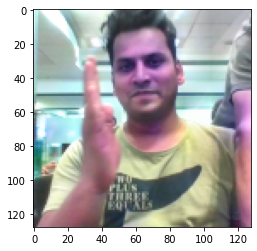

In [92]:
plt.imshow(equalize_adapthist(d)[0][7])

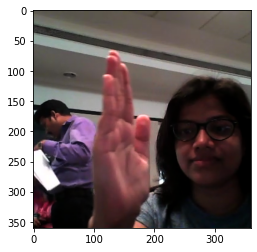

In [192]:
plt.imshow(randomGamma(sample_img, 1.36))

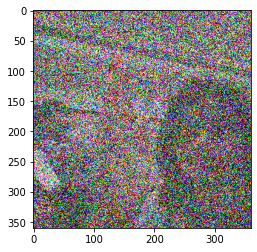

In [193]:
plt.imshow(randomNoise(sample_img, 1.36))

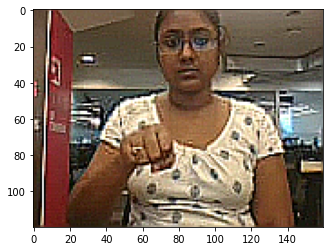

In [334]:
plt.imshow(np.array(Image.fromarray(samp, 'RGB').filter(ImageFilter.EDGE_ENHANCE)))

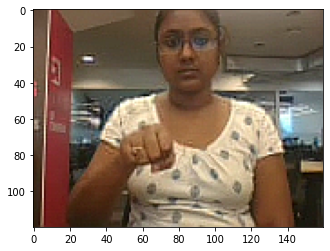

In [336]:
plt.imshow(np.array(Image.fromarray(samp, 'RGB').filter(ImageFilter.SHARPEN)))

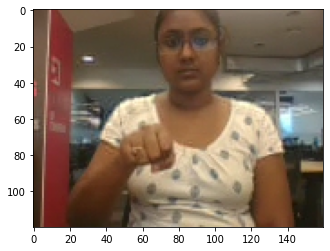

In [244]:
plt.imshow(samp)

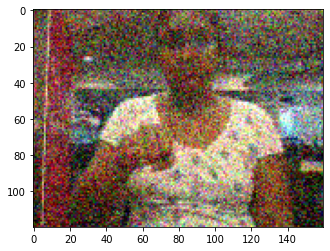

In [250]:
plt.imshow(random_noise(samp, var = 0.025))

In [51]:
gaussian(d[0])

array([[[[0.79510496, 0.84497864, 0.87470524],
         [0.75799657, 0.80321715, 0.830509  ],
         [0.73528485, 0.77329963, 0.7970514 ],
         ...,
         [0.62158859, 0.62335943, 0.62520962],
         [0.62188575, 0.62418443, 0.62752179],
         [0.6213995 , 0.6238426 , 0.62838914]],

        [[0.79266004, 0.84066018, 0.86979312],
         [0.75421728, 0.79818822, 0.82507579],
         [0.72748481, 0.7651163 , 0.78869633],
         ...,
         [0.62150036, 0.62327862, 0.62498897],
         [0.62115883, 0.62336963, 0.62634129],
         [0.6209044 , 0.62318017, 0.62706092]],

        [[0.7886242 , 0.8343329 , 0.86285494],
         [0.74796251, 0.79008924, 0.81629233],
         [0.71710818, 0.75370851, 0.77670604],
         ...,
         [0.62137249, 0.62301081, 0.62437663],
         [0.62023601, 0.62215612, 0.62449439],
         [0.61999745, 0.62194938, 0.62496668]],

        ...,

        [[0.20032792, 0.19587305, 0.19420498],
         [0.19465437, 0.19111024, 0.19004243]

#### Augmentation functions

In [11]:
# Augmentation utility functions
def randomGamma(im, var =  None): # var : 0.5 - 1.5
    if not var:
        print('ALERT -- picking random var')
        var = randRange(0.5, 1.5)
    return adjust_gamma(im, gamma=var)

def randomGaussian(im, var = None): # var : 0 - 3
    if not var:
        print('ALERT -- picking random var')
        var = randRange(0, 3)
    return gaussian(im, sigma=var,) 


def randomNoise(im, var = None): # var : 0.005 - 0.025
    if not var:
        print('ALERT -- picking random var')
        var = randRange(0.005, 0.025)
    return random_noise(im, var=var)

def randRange(a, b):
    return pl.rand() * (b - a) + a

def apply_equalize_adapthist(im, var):
    return equalize_adapthist(im)
def apply_equalize_hist(im, var):
    return equalize_hist(im)
def apply_adjust_log(im, var):
    return adjust_log(im)
def apply_adjust_sigmoid(im, var):
    return adjust_sigmoid(im)
def apply_sharpen(im, var):
    return np.array(Image.fromarray(im, 'RGB').filter(ImageFilter.SHARPEN))
def apply_enhance(im, var):
    return np.array(Image.fromarray(im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))




#### Generator with Augmentation 

In [12]:
def generator_with_augmentation(source_path, folder_list, batch_size, img_idx_to_select, augment = False, train_data = False, debug = False, aug_mul = 2, img_h = 128, img_w= 128): ##### Generator with Augmentation 
    img_idx = img_idx_to_select
    x = len(img_idx)
    y, z = img_h, img_w
    while True:
        if augment and train_data:
            t = np.random.permutation([item for item in folder_list for i in range(aug_mul)])
        else:
            t = np.random.permutation(folder_list)

        num_batches = math.ceil(len(t)/batch_size)
        remaining = len(t)%batch_size
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) 
            for folder in range(batch_size):
                folder_index = folder + (batch*batch_size) #handling lefout sequences
                if folder_index >= len(t):
                    break
                folder_str = t[folder_index]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) 
                if debug:
                    plt.figure(figsize=(20,5))
                    print(folder_str.strip().split(';')[1])
                if augment and train_data:
                    aug_type = np.random.choice([0, 1, 2])
                    if aug_type == 0: # augmentation with defaults
                        ifilter = np.random.choice([apply_equalize_hist, apply_equalize_adapthist, apply_adjust_log, apply_adjust_sigmoid])
                        var = 0
                    elif aug_type==1: #  augmentation w.random filter
                        ifilter_select = np.random.choice([1,2,3])
                        if ifilter_select == 1:
                            var = randRange(0, 3)
                            ifilter = randomGaussian
                        elif ifilter_select == 2:
                            var = randRange(0.5, 1.5)
                            ifilter = randomGamma
                        elif ifilter_select == 3:
                            var = randRange(0.005, 0.025)
                            ifilter = randomNoise
                    elif aug_type == 2: # no augmentation
                        ifilter = None
                        var = None
                    if debug:
                        print(ifilter, var)
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item])
                    image = resize(image, (y, z))
                                       
                    if augment and train_data:
                        if aug_type != 2:
                            image = ifilter(image, var = var)
                            
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                        

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [26]:
def setup_data_with_aug(img_h = 128, img_w = 128, batch_size = 64):  # helper function to quickly setup data for training
    global train_generator, val_generator, steps_per_epoch, validation_steps, num_train_sequences, num_val_sequences
    
    train_generator = generator_with_augmentation(train_path, train_doc, 64, img_idx_to_select= img_idx_to_select, debug = False, augment = True, train_data = True, aug_mul= 3, img_h=  img_h, img_w = img_w)
    val_generator = generator_with_augmentation(val_path, val_doc, 64, img_idx_to_select= img_idx_to_select, debug = False, augment = False, train_data = False, img_h=  img_h, img_w = img_w)
    
    num_train_sequences = len(train_doc) *3
    num_val_sequences = len(val_doc)

    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    

#### Testing new gen.

In [16]:
train_doc, val_doc = fetch_data(abalition=10)

In [17]:
train_doc

array(['WIN_20180926_17_11_24_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180907_16_25_22_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
       'WIN_20180925_17_29_33_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180925_18_12_58_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_17_18_28_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_32_14_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180925_17_18_07_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_06_30_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180926_16_39_45_Pro_Right_Swipe_new;Right_Swipe_new;1\n'],
      dtype='<U88')

In [23]:
gen = generator_with_augmentation(train_path, train_doc, 10, img_idx_to_select= range(0,30,2), debug = True, augment = True, train_data = True )


Thumbs_Up_new
<function apply_adjust_log at 0x7fc009799af0> 0
Left_Swipe_new
<function randomGamma at 0x7fc009799700> 0.9217997413502117
Right_Swipe_new
None None
Right_Swipe_new
<function apply_adjust_log at 0x7fc009799af0> 0
Left Swipe_new_Left Swipe_new
<function randomGamma at 0x7fc009799700> 0.5842076114139452
Thumbs_Down_new
<function apply_equalize_adapthist at 0x7fc009799940> 0
Thumbs_Down_new
None None
Thumbs_Up_new
None None
Left Swipe_new_Left Swipe_new
None None
Thumbs_Down_new
<function apply_equalize_hist at 0x7fc009799a60> 0


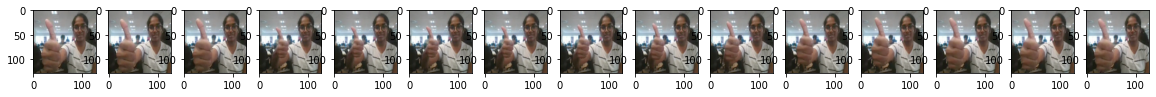

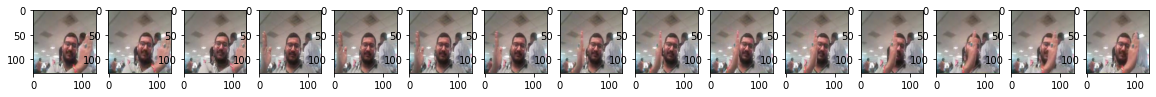

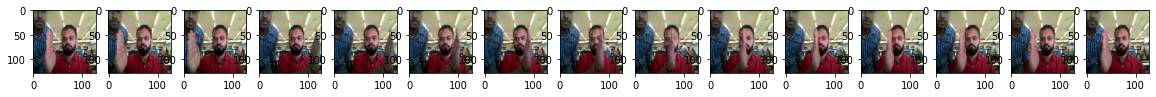

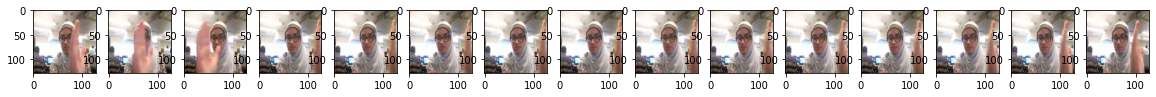

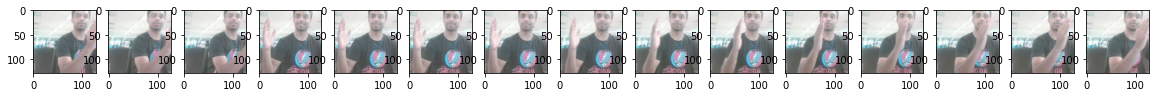

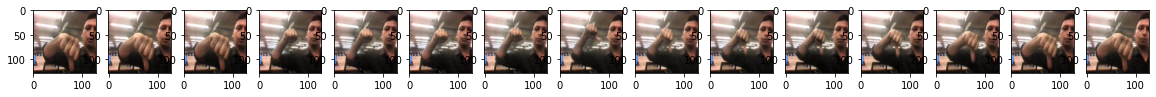

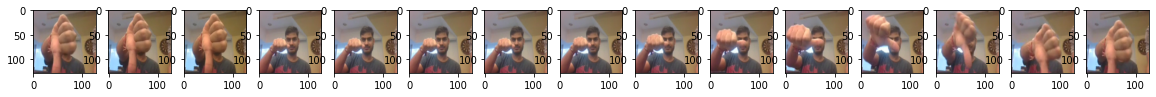

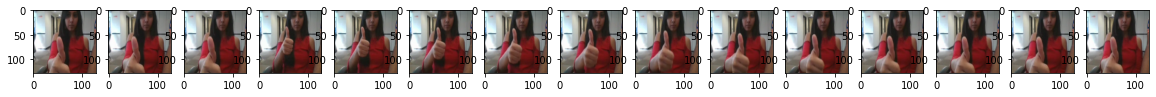

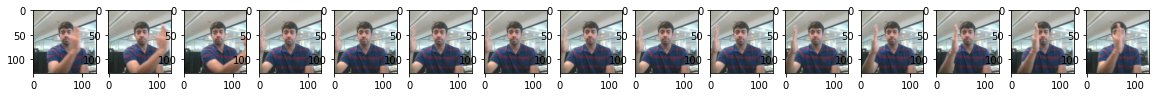

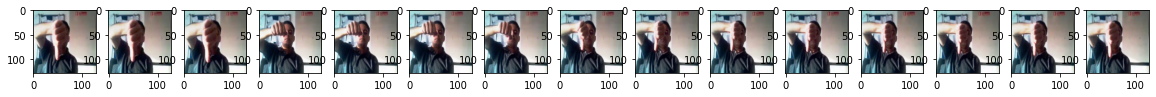

In [24]:
d, l  = next(gen)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels).

In [57]:
# to visualise train v validation performance
def visualise_model_res(hist, epochs):
    acc = hist.history['categorical_accuracy']
    val_acc = hist.history['val_categorical_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### helper function to build cond 2d CNNs for RNN 

In [59]:
def make_2d_cnn(shape, conv_filters = [32,64,128,256]):
    momentum = 0.9
    model = keras.Sequential()
    model.add(Conv2D(conv_filters[0], (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(conv_filters[0], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(conv_filters[1], (3,3), padding='same', activation='relu'))
    model.add(Conv2D(conv_filters[1], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(conv_filters[2], (3,3), padding='same', activation='relu'))
    model.add(Conv2D(conv_filters[2], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(conv_filters[3], (3,3), padding='same', activation='relu'))
    model.add(Conv2D(conv_filters[3], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool2D())
    return model

In [28]:
def make_2d_cnn_1_unit(shape, conv_filters = [32,64,128,256], global_mp = True, flatten = False):
    momentum = 0.9
    model = keras.Sequential()
    model.add(Conv2D(conv_filters[0], (3,3), input_shape=shape,
        padding='same', activation='relu'))
#     model.add(Conv2D(conv_filters[0], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(conv_filters[1], (3,3), padding='same', activation='relu'))
#     model.add(Conv2D(conv_filters[1], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(conv_filters[2], (3,3), padding='same', activation='relu'))
#     model.add(Conv2D(conv_filters[2], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(conv_filters[3], (3,3), padding='same', activation='relu'))
    model.add(Conv2D(conv_filters[3], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    if global_mp:
        model.add(GlobalMaxPool2D())
    if flatten:
        model.add(Flatten())
    return model

In [57]:
pre_trained = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet')

In [26]:
train_doc, val_doc = fetch_data(abalition=False)

In [25]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Modeling

In [13]:
input_shape = (len(img_idx_to_select), img_h, img_w, 3)
num_classes = 5

In [39]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto',)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 ,
                              patience=5, min_lr=0)
callbacks_list = [checkpoint, reduce_lr]

In [40]:
optim_sgd = keras.optimizers.SGD(learning_rate=0.001, decay = 0.01)

In [41]:
optim_adam = keras.optimizers.Adam()

## 3d convolution based models

#### Model 1

In [18]:
model_0 = Sequential([
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(num_classes, activation = 'softmax')
])

2022-11-09 19:30:50.372420: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-09 19:30:50.372485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [20]:
model_0.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [34]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 126, 126, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 63, 63, 32)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 63, 63, 32)    128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 61, 61, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 30, 30, 64)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [25]:
setup_data()

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
model_0.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /home/datasets/Project_data/train/ ; batch size = 64
total batches -- 11
Epoch 1/10


2022-11-09 19:31:31.138465: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.4093 - categorical_accuracy: 0.4247Source path =  /home/datasets/Project_data/val/ ; batch size = 64
total batches -- 2
total batches -- 2
11/11 [==============================] - 82s 8s/step - loss: 1.4093 - categorical_accuracy: 0.4247 - val_loss: 1.2502 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - 79s 8s/step - loss: 0.5620 - categorical_accuracy: 0.7727 - val_loss: 1.2418 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 0.3116 - categorical_accuracy: 0.8778total batches -- 2
total batches -- 2
11/11 [==============================] - 80s 8s/step - loss: 0.3116 - categorical_accuracy: 0.8778 - val_loss: 1.2558 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 4/10
11/11 [==============================] - 78s 8s/step - loss: 0.2063 - categorical_accuracy: 0.9190 - val_loss: 1.2766 - val_categorical_acc

KeyboardInterrupt: 

### Model 2
- Adding droput

In [39]:
model_1 = Sequential([
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [40]:
model_1.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [41]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 13, 126, 126, 32)  2624      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 63, 63, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 6, 63, 63, 32)    128       
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 4, 61, 61, 64)     55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 30, 30, 64)    0         
 3D)                                                             
                                                      

In [42]:
model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/10
11/11 [==============================] - 83s 8s/step - loss: 1.8215 - categorical_accuracy: 0.2670 - val_loss: 1.2256 - val_categorical_accuracy: 0.2344 - lr: 5.0000e-04
Epoch 2/10
11/11 [==============================] - 78s 8s/step - loss: 1.2935 - categorical_accuracy: 0.4134 - val_loss: 1.2228 - val_categorical_accuracy: 0.1719 - lr: 5.0000e-04
Epoch 3/10
11/11 [==============================] - 82s 8s/step - loss: 1.0568 - categorical_accuracy: 0.5384 - val_loss: 1.2229 - val_categorical_accuracy: 0.2891 - lr: 5.0000e-04
Epoch 4/10
11/11 [==============================] - 77s 8s/step - loss: 0.8583 - categorical_accuracy: 0.6136 - val_loss: 1.2594 - val_categorical_accuracy: 0.2031 - lr: 5.0000e-04
Epoch 5/10
11/11 [==============================] - 81s 8s/step - loss: 0.7861 - categorical_accuracy: 0.6648 - val_loss: 1.2884 - val_categorical_accuracy: 0.1641 - lr: 5.0000e-04
Epoch 6/10
11/11 [==============================] - 78s 8s/step - loss: 0.6719 - categorical_ac

### Model 3
- Deeper model with less params

In [26]:
model_2 = Sequential([
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'valid', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu',padding = 'valid',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [28]:
setup_data()

In [27]:
model_2.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [30]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 13, 126, 126, 32)  2624      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 63, 63, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 6, 63, 63, 32)    128       
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 4, 61, 61, 64)     55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 30, 30, 64)    0         
 3D)                                                             
                                                      

In [33]:
model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20


2022-11-09 21:18:31.040530: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - 82s 8s/step - loss: 1.8937 - categorical_accuracy: 0.2884 - val_loss: 1.2485 - val_categorical_accuracy: 0.2266 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 79s 8s/step - loss: 1.2887 - categorical_accuracy: 0.4602 - val_loss: 1.2694 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 81s 8s/step - loss: 0.9226 - categorical_accuracy: 0.5881 - val_loss: 1.3028 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 78s 8s/step - loss: 0.7790 - categorical_accuracy: 0.6435 - val_loss: 1.3524 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 81s 8s/step - loss: 0.6771 - categorical_accuracy: 0.6861 - val_loss: 1.4027 - val_categorical_accuracy: 0.1641 - lr: 5.0000e-04
Epoch 6/20
11/11 [==============================] - 78s 8s/step - loss: 0.6245 - categorical_accuracy: 0.7259 - val_loss: 

KeyboardInterrupt: 

#### Model 4

In [34]:
model_3 = Sequential([
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [35]:
setup_data()

In [36]:
model_3.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [37]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 64, 64, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 7, 64, 64, 32)    128       
 hNormalization)                                                 
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 64, 64, 64)     55360     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 32, 32, 64)    0         
 g3D)                                                            
                                                      

In [38]:
model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 83s 8s/step - loss: 2.1383 - categorical_accuracy: 0.2401 - val_loss: 1.2721 - val_categorical_accuracy: 0.3203 - lr: 5.0000e-04
Epoch 2/20
11/11 [==============================] - 77s 8s/step - loss: 1.7195 - categorical_accuracy: 0.2969 - val_loss: 1.2868 - val_categorical_accuracy: 0.3281 - lr: 5.0000e-04
Epoch 3/20
11/11 [==============================] - 82s 8s/step - loss: 1.4967 - categorical_accuracy: 0.3722 - val_loss: 1.3060 - val_categorical_accuracy: 0.3594 - lr: 5.0000e-04
Epoch 4/20
11/11 [==============================] - 78s 8s/step - loss: 1.4113 - categorical_accuracy: 0.4148 - val_loss: 1.2867 - val_categorical_accuracy: 0.4141 - lr: 5.0000e-04
Epoch 5/20
11/11 [==============================] - 81s 8s/step - loss: 1.2908 - categorical_accuracy: 0.4545 - val_loss: 1.3628 - val_categorical_accuracy: 0.3594 - lr: 5.0000e-04
Epoch 6/20
11/11 [==============================] - 78s 8s/step - loss: 1.1717 - categorical_ac

KeyboardInterrupt: 

In [40]:
model_4 = Sequential([
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

In [41]:
setup_data()

In [42]:
model_4.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [43]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 64, 64, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 7, 64, 64, 32)    128       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 64, 64, 64)     55360     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 3, 32, 32, 64)    0         
 g3D)                                                            
                                                      

In [44]:
model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 82s 8s/step - loss: 2.7340 - categorical_accuracy: 0.1946 - val_loss: 1.2543 - val_categorical_accuracy: 0.1719 - lr: 5.0000e-04
Epoch 2/20
11/11 [==============================] - 78s 8s/step - loss: 2.3091 - categorical_accuracy: 0.2386 - val_loss: 1.2614 - val_categorical_accuracy: 0.1328 - lr: 5.0000e-04
Epoch 3/20
11/11 [==============================] - 81s 8s/step - loss: 2.0618 - categorical_accuracy: 0.2841 - val_loss: 1.2665 - val_categorical_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 4/20
11/11 [==============================] - 79s 8s/step - loss: 1.9180 - categorical_accuracy: 0.3338 - val_loss: 1.2980 - val_categorical_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 5/20
11/11 [==============================] - 81s 8s/step - loss: 1.6797 - categorical_accuracy: 0.3793 - val_loss: 1.3085 - val_categorical_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 6/20
11/11 [==============================] - 77s 8s/step - loss: 1.7574 - categorical_ac

KeyboardInterrupt: 

In [45]:
model_5 = Sequential([
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [46]:
setup_data()

In [47]:
model_5.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [48]:
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 15, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 7, 64, 64, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 7, 64, 64, 32)    128       
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 7, 64, 64, 64)     55360     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 3, 32, 32, 64)    0         
 g3D)                                                            
                                                      

In [49]:
model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 82s 8s/step - loss: 2.5514 - categorical_accuracy: 0.1889 - val_loss: 1.2615 - val_categorical_accuracy: 0.1797 - lr: 5.0000e-04
Epoch 2/20
11/11 [==============================] - 79s 8s/step - loss: 2.1278 - categorical_accuracy: 0.2443 - val_loss: 1.2650 - val_categorical_accuracy: 0.1484 - lr: 5.0000e-04
Epoch 3/20
11/11 [==============================] - 81s 8s/step - loss: 1.9698 - categorical_accuracy: 0.2756 - val_loss: 1.2710 - val_categorical_accuracy: 0.1328 - lr: 5.0000e-04
Epoch 4/20
11/11 [==============================] - 78s 8s/step - loss: 1.8836 - categorical_accuracy: 0.2741 - val_loss: 1.2704 - val_categorical_accuracy: 0.1328 - lr: 5.0000e-04
Epoch 5/20
11/11 [==============================] - 81s 8s/step - loss: 1.6367 - categorical_accuracy: 0.3366 - val_loss: 1.2750 - val_categorical_accuracy: 0.1719 - lr: 5.0000e-04
Epoch 6/20
11/11 [==============================] - 78s 8s/step - loss: 1.5594 - categorical_ac

KeyboardInterrupt: 

In [60]:
model_6 = Sequential([
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [61]:
setup_data()

In [62]:
model_6.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [63]:
model_6.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 15, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 7, 64, 64, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 7, 64, 64, 32)    128       
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 7, 64, 64, 64)     55360     
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 3, 32, 32, 64)    0         
 g3D)                                                            
                                                      

In [64]:
model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 82s 8s/step - loss: 2.3157 - categorical_accuracy: 0.2244 - val_loss: 1.2673 - val_categorical_accuracy: 0.1562 - lr: 5.0000e-04
Epoch 2/20
11/11 [==============================] - 78s 8s/step - loss: 2.0831 - categorical_accuracy: 0.2429 - val_loss: 1.2801 - val_categorical_accuracy: 0.1172 - lr: 5.0000e-04
Epoch 3/20
11/11 [==============================] - 80s 8s/step - loss: 1.7869 - categorical_accuracy: 0.3082 - val_loss: 1.2923 - val_categorical_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 4/20
11/11 [==============================] - 79s 8s/step - loss: 1.6582 - categorical_accuracy: 0.3310 - val_loss: 1.2797 - val_categorical_accuracy: 0.1641 - lr: 5.0000e-04
Epoch 5/20
11/11 [==============================] - 81s 8s/step - loss: 1.5575 - categorical_accuracy: 0.3679 - val_loss: 1.3397 - val_categorical_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 6/20
11/11 [==============================] - 79s 8s/step - loss: 1.4510 - categorical_ac

KeyboardInterrupt: 

In [66]:
model_7 = Sequential([
    Conv3D(filters = 32, kernel_size = 2, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 2, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 2, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [69]:
model_7.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [70]:
model_7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 15, 128, 128, 32)  800       
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 7, 64, 64, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 7, 64, 64, 32)    128       
 chNormalization)                                                
                                                                 
 conv3d_31 (Conv3D)          (None, 7, 64, 64, 64)     16448     
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 3, 32, 32, 64)    0         
 g3D)                                                            
                                                     

In [71]:
model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 82s 8s/step - loss: 2.1987 - categorical_accuracy: 0.2131 - val_loss: 1.2528 - val_categorical_accuracy: 0.1719 - lr: 5.0000e-04
Epoch 2/20
11/11 [==============================] - 79s 8s/step - loss: 1.9462 - categorical_accuracy: 0.2415 - val_loss: 1.2592 - val_categorical_accuracy: 0.1797 - lr: 5.0000e-04
Epoch 3/20
11/11 [==============================] - 82s 8s/step - loss: 1.8423 - categorical_accuracy: 0.2685 - val_loss: 1.2613 - val_categorical_accuracy: 0.1797 - lr: 5.0000e-04
Epoch 4/20
11/11 [==============================] - 78s 8s/step - loss: 1.7200 - categorical_accuracy: 0.2741 - val_loss: 1.2698 - val_categorical_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 5/20
11/11 [==============================] - 82s 8s/step - loss: 1.6653 - categorical_accuracy: 0.2926 - val_loss: 1.2780 - val_categorical_accuracy: 0.1328 - lr: 5.0000e-04
Epoch 6/20
11/11 [==============================] - 78s 8s/step - loss: 1.6291 - categorical_ac

KeyboardInterrupt: 

#### Model 9

In [92]:
model_8 = Sequential([
    Conv3D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [93]:
setup_data()

In [94]:
adam = keras.optimizers.Adam(learning_rate=0.001,)

In [95]:
model_8.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [96]:
model_8.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 15, 128, 128, 16)  1312      
                                                                 
 max_pooling3d_45 (MaxPoolin  (None, 7, 64, 64, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_45 (Bat  (None, 7, 64, 64, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_46 (Conv3D)          (None, 7, 64, 64, 32)     13856     
                                                                 
 max_pooling3d_46 (MaxPoolin  (None, 3, 32, 32, 32)    0         
 g3D)                                                            
                                                     

In [97]:
model_8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    callbacks=[reduce_lr], validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 81s 8s/step - loss: 1.7992 - categorical_accuracy: 0.3679 - val_loss: 1.2416 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 78s 8s/step - loss: 1.2518 - categorical_accuracy: 0.5497 - val_loss: 1.3085 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 81s 8s/step - loss: 0.8626 - categorical_accuracy: 0.6634 - val_loss: 1.4122 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 77s 8s/step - loss: 0.7737 - categorical_accuracy: 0.6818 - val_loss: 1.7490 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 81s 8s/step - loss: 0.6810 - categorical_accuracy: 0.7287 - val_loss: 1.6574 - val_categorical_accuracy: 0.3438 - lr: 5.0000e-04
Epoch 6/20
11/11 [==============================] - 79s 8s/step - loss: 0.6499 - categorical_accuracy: 0.7443 -

KeyboardInterrupt: 

In [82]:
str(5.0000e-04)

'0.0005'

### conv 3D with augmentations

In [22]:
train_doc, val_doc = fetch_data(abalition=False)

In [23]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [24]:
# gen = generator_with_augmentation(train_path, train_doc, 5, img_idx_to_select= range(0,30,2), debug = True, augment = True, train_data = True )

In [25]:
input_shape = (len(img_idx_to_select), img_h, img_w, 3)
num_classes = 5

In [19]:
setup_data_with_aug()

#### Model 10

In [21]:
model_0_aug = Sequential([
    Conv3D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

2022-11-12 02:17:45.889901: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-12 02:17:45.889966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


In [26]:
model_0_aug.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [28]:
model_0_aug.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 95s 9s/step - loss: 1.7848 - categorical_accuracy: 0.4062 - val_loss: 1.3447 - val_categorical_accuracy: 0.2109
Epoch 2/20
11/11 [==============================] - 90s 9s/step - loss: 1.2705 - categorical_accuracy: 0.5611 - val_loss: 1.4145 - val_categorical_accuracy: 0.1953
Epoch 3/20
11/11 [==============================] - 89s 9s/step - loss: 1.3924 - categorical_accuracy: 0.5710 - val_loss: 1.6229 - val_categorical_accuracy: 0.1797
Epoch 4/20
11/11 [==============================] - 92s 9s/step - loss: 1.0261 - categorical_accuracy: 0.6761 - val_loss: 1.2088 - val_categorical_accuracy: 0.2500
Epoch 5/20
11/11 [==============================] - 95s 9s/step - loss: 0.7152 - categorical_accuracy: 0.7287 - val_loss: 2.6116 - val_categorical_accuracy: 0.1250
Epoch 6/20
 4/11 [=========>....................] - ETA: 51s - loss: 0.6245 - categorical_accuracy: 0.7773

KeyboardInterrupt: 

In [30]:
model_1_aug = Sequential([
    Conv3D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    Dropout(0.1),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [32]:
model_1_aug.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [33]:
model_1_aug.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,)

/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


Epoch 1/20
11/11 [==============================] - 91s 9s/step - loss: 2.1145 - categorical_accuracy: 0.3352 - val_loss: 3.4551 - val_categorical_accuracy: 0.2109
Epoch 2/20
11/11 [==============================] - 96s 10s/step - loss: 1.6255 - categorical_accuracy: 0.4361 - val_loss: 4.3516 - val_categorical_accuracy: 0.1719
Epoch 3/20
11/11 [==============================] - 85s 8s/step - loss: 1.6543 - categorical_accuracy: 0.4886 - val_loss: 2.1720 - val_categorical_accuracy: 0.1875
Epoch 4/20
11/11 [==============================] - 96s 10s/step - loss: 1.2350 - categorical_accuracy: 0.5497 - val_loss: 2.7833 - val_categorical_accuracy: 0.1484
Epoch 5/20
11/11 [==============================] - ETA: 0s - loss: 1.0674 - categorical_accuracy: 0.6349

KeyboardInterrupt: 

#### Model 11

In [37]:
model_2_aug = Sequential([
    Conv3D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2, padding = 'same'),
    BatchNormalization(),
    
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [38]:
model_2_aug.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [39]:
model_2_aug.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,)

Epoch 1/20
11/11 [==============================] - 87s 9s/step - loss: 1.7567 - categorical_accuracy: 0.3097 - val_loss: 1.2534 - val_categorical_accuracy: 0.3906
Epoch 2/20
11/11 [==============================] - 96s 10s/step - loss: 1.4240 - categorical_accuracy: 0.4688 - val_loss: 1.5964 - val_categorical_accuracy: 0.2578
Epoch 3/20
11/11 [==============================] - 90s 9s/step - loss: 1.0238 - categorical_accuracy: 0.5739 - val_loss: 1.5008 - val_categorical_accuracy: 0.2891
Epoch 4/20
11/11 [==============================] - 90s 9s/step - loss: 0.7996 - categorical_accuracy: 0.6151 - val_loss: 2.5699 - val_categorical_accuracy: 0.1406
Epoch 5/20
11/11 [==============================] - 90s 9s/step - loss: 0.7722 - categorical_accuracy: 0.7216 - val_loss: 0.9885 - val_categorical_accuracy: 0.3906
Epoch 6/20
11/11 [==============================] - 96s 10s/step - loss: 0.6176 - categorical_accuracy: 0.7685 - val_loss: 2.4166 - val_categorical_accuracy: 0.2344
Epoch 7/20
11/

KeyboardInterrupt: 

In [46]:
model_3_aug = Sequential([
    Conv3D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    Dropout(0.15),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2, padding = 'same'),
    BatchNormalization(),
    
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

In [47]:
setup_data_with_aug()

In [48]:
model_3_aug.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [49]:
model_3_aug.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,)

/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


Epoch 1/20
11/11 [==============================] - 95s 9s/step - loss: 1.8103 - categorical_accuracy: 0.3580 - val_loss: 1.4922 - val_categorical_accuracy: 0.1875
Epoch 2/20
11/11 [==============================] - 92s 9s/step - loss: 1.4924 - categorical_accuracy: 0.4020 - val_loss: 12.8818 - val_categorical_accuracy: 0.1875
Epoch 3/20
11/11 [==============================] - 89s 9s/step - loss: 1.3380 - categorical_accuracy: 0.4631 - val_loss: 2.6246 - val_categorical_accuracy: 0.2422
Epoch 4/20
11/11 [==============================] - 92s 9s/step - loss: 1.1663 - categorical_accuracy: 0.5483 - val_loss: 2.9409 - val_categorical_accuracy: 0.1328
Epoch 5/20
11/11 [==============================] - 97s 10s/step - loss: 1.0793 - categorical_accuracy: 0.5852 - val_loss: 1.5682 - val_categorical_accuracy: 0.1562
Epoch 6/20
11/11 [==============================] - 83s 8s/step - loss: 0.9187 - categorical_accuracy: 0.5625 - val_loss: 1.1540 - val_categorical_accuracy: 0.2969
Epoch 7/20
11/

In [32]:
model_4_aug = Sequential([
    Conv3D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2),
    BatchNormalization(),
    
    Conv3D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',),
    MaxPooling3D(pool_size = 2, padding = 'same'),
    BatchNormalization(),
    
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])

2022-11-12 14:03:28.281971: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-12 14:03:28.282027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [33]:
setup_data_with_aug()

In [34]:
model_4_aug.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [35]:
model_4_aug_hist = model_4_aug.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = [reduce_lr])

Epoch 1/50


2022-11-12 14:06:10.195569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - 111s 10s/step - loss: 1.8129 - categorical_accuracy: 0.2955 - val_loss: 1.2643 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 107s 11s/step - loss: 1.5032 - categorical_accuracy: 0.3693 - val_loss: 1.2995 - val_categorical_accuracy: 0.0938 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 98s 10s/step - loss: 1.3664 - categorical_accuracy: 0.4290 - val_loss: 1.2918 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 106s 11s/step - loss: 1.3199 - categorical_accuracy: 0.4616 - val_loss: 1.3411 - val_categorical_accuracy: 0.3281 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 108s 11s/step - loss: 1.0825 - categorical_accuracy: 0.5923 - val_loss: 1.3832 - val_categorical_accuracy: 0.3594 - lr: 5.0000e-04
Epoch 6/50
11/11 [==============================] - 97s 10s/step - loss: 0.8837 - categorical_accuracy: 0.6222 - 

KeyboardInterrupt: 

#### Conv2d + RNNs

#### Model 14

### GRU

#### Model 15

In [47]:
convnet_2d = make_2d_cnn(input_shape[1:])
rnn_gru = Sequential([
    TimeDistributed(convnet_2d, input_shape = input_shape),
    
    GRU(64),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [48]:
rnn_gru.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [49]:
rnn_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 15, 256)          1174176   
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)                61824     
                                                                 
 dense_6 (Dense)             (None, 256)               16640     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

In [50]:
setup_data_with_aug()

In [51]:
rnn_gru_hist = rnn_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = [reduce_lr])

Epoch 1/50


2022-11-12 14:54:07.232424: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-12 14:54:07.753994: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-12 14:54:07.874877: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-12 14:54:07.874910: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

11/11 [==============================] - 110s 10s/step - loss: 1.6865 - categorical_accuracy: 0.2102 - val_loss: 1.2660 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 104s 10s/step - loss: 1.6313 - categorical_accuracy: 0.2173 - val_loss: 1.2956 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 97s 10s/step - loss: 1.4860 - categorical_accuracy: 0.2116 - val_loss: 1.2402 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 106s 10s/step - loss: 1.6137 - categorical_accuracy: 0.2116 - val_loss: 1.2446 - val_categorical_accuracy: 0.3672 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 108s 11s/step - loss: 1.5898 - categorical_accuracy: 0.2557 - val_loss: 1.2349 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 99s 10s/step - loss: 1.4631 - categorical_accuracy: 0.2315 - val_

### GRU with shallower CNN2d

#### Model 17

In [37]:
convnet_2d_1_unit = make_2d_cnn_1_unit(input_shape[1:])
rnn_gru_1 = Sequential([
    TimeDistributed(convnet_2d_1_unit, input_shape = input_shape),
    
    GRU(64),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

2022-11-13 12:11:42.838446: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-13 12:11:42.838528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [38]:
rnn_gru_1.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [39]:
rnn_gru_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 256)          980416    
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 64)                61824     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [40]:
setup_data_with_aug()

In [63]:
rnn_gru_1_hist = rnn_gru_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = [reduce_lr])

Epoch 1/50
11/11 [==============================] - 114s 11s/step - loss: 1.6814 - categorical_accuracy: 0.2017 - val_loss: 1.2579 - val_categorical_accuracy: 0.1641 - lr: 1.0000e-04
Epoch 2/50
11/11 [==============================] - 106s 11s/step - loss: 1.6211 - categorical_accuracy: 0.2344 - val_loss: 1.2647 - val_categorical_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 3/50
11/11 [==============================] - 98s 10s/step - loss: 1.4948 - categorical_accuracy: 0.2173 - val_loss: 1.2539 - val_categorical_accuracy: 0.3516 - lr: 1.0000e-04
Epoch 4/50
11/11 [==============================] - 104s 10s/step - loss: 1.6054 - categorical_accuracy: 0.2415 - val_loss: 1.2238 - val_categorical_accuracy: 0.2734 - lr: 1.0000e-04
Epoch 5/50
11/11 [==============================] - 106s 11s/step - loss: 1.5792 - categorical_accuracy: 0.2741 - val_loss: 1.2111 - val_categorical_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 6/50
11/11 [==============================] - 97s 10s/step - loss: 1.4595 - cate

In [41]:
rnn_gru_1_hist = rnn_gru_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = [checkpoint, reduce_lr])

Epoch 1/50


2022-11-13 12:12:34.772879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - 114s 11s/step - loss: 1.6601 - categorical_accuracy: 0.2259 - val_loss: 1.2635 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 107s 11s/step - loss: 1.6210 - categorical_accuracy: 0.2116 - val_loss: 1.2627 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 100s 10s/step - loss: 1.4936 - categorical_accuracy: 0.2131 - val_loss: 1.2447 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 103s 10s/step - loss: 1.5966 - categorical_accuracy: 0.2500 - val_loss: 1.2455 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 104s 10s/step - loss: 1.5966 - categorical_accuracy: 0.2628 - val_loss: 1.2215 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 98s 10s/step - loss: 1.4456 - categorical_accuracy: 0.2386 - val

In [46]:
model_convlstm = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape),
    BatchNormalization(),
    
    TimeDistributed(Conv2D(16, (3,3), activation='relu'), input_shape=input_shape),
    BatchNormalization(),
    
    ConvLSTM2D(8, (3,3), return_sequences=False),
    BatchNormalization(),
    
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
    
])

#### Model 18

In [47]:
model_convlstm.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [48]:
model_convlstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 15, 126, 126, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 15, 126, 126, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 124, 124, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 15, 124, 124, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 122, 122, 8)      

In [49]:
callbacks_list

In [50]:
setup_data_with_aug()

In [51]:
model_convlstm_hist = model_convlstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.5523 - categorical_accuracy: 0.3366
Epoch 00001: saving model to model_init_2022-11-1218_04_09.598676/model-00001-1.55227-0.33665-0.35938.h5
11/11 [==============================] - 111s 11s/step - loss: 1.5523 - categorical_accuracy: 0.3366 - val_loss: 1.2580 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.4889 - categorical_accuracy: 0.3466
Epoch 00002: saving model to model_init_2022-11-1218_04_09.598676/model-00002-1.48894-0.34659-0.35156.h5
11/11 [==============================] - 101s 10s/step - loss: 1.4889 - categorical_accuracy: 0.3466 - val_loss: 1.2575 - val_categorical_accuracy: 0.3516 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.3545 - categorical_accuracy: 0.3494
Epoch 00003: saving model to model_init_2022-11-1218_04_09.598676/model-00003-1.35454-0.34943-0.17188.h5
11/11 [========================

KeyboardInterrupt: 

#### GRU with pre-trained mobilenet 

#### Model 19

In [57]:
pre_trained = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet')

In [58]:
mobilenet = build_application(pre_trained, 9) # mobilnet model with 9 trainable layers

In [59]:
mobilenet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
Total params: 3,228,864
Trainable params: 1,588,224
Non-trainable params: 1,640,640
_________________________________________________________________


In [60]:
input_shape

(15, 128, 128, 3)

In [61]:
rnn_gru_mobilenet = Sequential([
    TimeDistributed(mobilenet, input_shape = (15, 224, 224, 3)),
    
    GRU(64),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [62]:
rnn_gru_mobilenet.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [63]:
rnn_gru_mobilenet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 15, 1024)         3228864   
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 64)                209280    
                                                                 
 dense_8 (Dense)             (None, 256)               16640     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

In [64]:
setup_data_with_aug(224, 224)

In [65]:
rnn_gru_mobilenet_hist = rnn_gru_mobilenet.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/50
11/11 [==============================] - 190s 19s/step - loss: 1.6838 - categorical_accuracy: 0.2372 - val_loss: 1.2750 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 185s 18s/step - loss: 1.6483 - categorical_accuracy: 0.1974 - val_loss: 1.2604 - val_categorical_accuracy: 0.1328 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 169s 17s/step - loss: 1.4973 - categorical_accuracy: 0.1918 - val_loss: 1.2652 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 180s 18s/step - loss: 1.6198 - categorical_accuracy: 0.2244 - val_loss: 1.2671 - val_categorical_accuracy: 0.3359 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 183s 18s/step - loss: 1.6247 - categorical_accuracy: 0.1776 - val_loss: 1.2610 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 163s 16s/step - loss: 1.4802 - categorical_accuracy: 

KeyboardInterrupt: 

### GRU with shallower CNN2d

#### Model 20

In [91]:
convnet_2d_1_unit = make_2d_cnn_1_unit(input_shape[1:], conv_filters = [16,32,64,128])
rnn_gru_2 = Sequential([
    TimeDistributed(convnet_2d_1_unit, input_shape = input_shape),
    
    GRU(64),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [92]:
rnn_gru_2.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [93]:
rnn_gru_2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 15, 128)          245984    
 tributed)                                                       
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dense_36 (Dense)            (None, 256)               16640     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                     

In [80]:
setup_data_with_aug()

In [81]:
rnn_gru_2_hist = rnn_gru_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/50
11/11 [==============================] - 114s 11s/step - loss: 1.6790 - categorical_accuracy: 0.1889 - val_loss: 1.2626 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 109s 11s/step - loss: 1.6232 - categorical_accuracy: 0.2145 - val_loss: 1.2557 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 109s 11s/step - loss: 1.4572 - categorical_accuracy: 0.2131 - val_loss: 1.2367 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 106s 11s/step - loss: 1.5796 - categorical_accuracy: 0.2386 - val_loss: 1.2107 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 110s 11s/step - loss: 1.5513 - categorical_accuracy: 0.2869 - val_loss: 1.1594 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 100s 10s/step - loss: 1.3735 - categorical_accuracy: 

#### Model 21

In [134]:
convnet_2d_1_unit = make_2d_cnn_1_unit(input_shape[1:], conv_filters = [8,16,32,64])
rnn_gru_3 = Sequential([
    TimeDistributed(convnet_2d_1_unit, input_shape = input_shape),
    
    GRU(32),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [135]:
rnn_gru_3.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [136]:
rnn_gru_3.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 15, 64)           61936     
 stributed)                                                      
                                                                 
 gru_20 (GRU)                (None, 32)                9408      
                                                                 
 dense_80 (Dense)            (None, 128)               4224      
                                                                 
 dropout_40 (Dropout)        (None, 128)               0         
                                                                 
 dense_81 (Dense)            (None, 64)                8256      
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                     

In [137]:
setup_data_with_aug()

In [138]:
rnn_gru_3_hist = rnn_gru_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/50
11/11 [==============================] - 116s 11s/step - loss: 1.6990 - categorical_accuracy: 0.2074 - val_loss: 1.2687 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 103s 10s/step - loss: 1.6283 - categorical_accuracy: 0.2031 - val_loss: 1.2597 - val_categorical_accuracy: 0.1328 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 106s 11s/step - loss: 1.4797 - categorical_accuracy: 0.2116 - val_loss: 1.2560 - val_categorical_accuracy: 0.1484 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 112s 11s/step - loss: 1.5896 - categorical_accuracy: 0.2330 - val_loss: 1.2639 - val_categorical_accuracy: 0.1484 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 114s 11s/step - loss: 1.6022 - categorical_accuracy: 0.2173 - val_loss: 1.1992 - val_categorical_accuracy: 0.3359 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 105s 10s/step - loss: 1.4507 - categorical_accuracy: 

KeyboardInterrupt: 

In [152]:
convnet_2d_1_unit = make_2d_cnn_1_unit(input_shape[1:], global_mp=False, flatten=True) # using flatten insted of gloabal avg. pooling
rnn_gru_4 = Sequential([
    TimeDistributed(convnet_2d_1_unit, input_shape = input_shape),
    
    GRU(64),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [153]:
rnn_gru_4.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [154]:
rnn_gru_4.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 15, 65536)        980416    
 stributed)                                                      
                                                                 
 gru_23 (GRU)                (None, 64)                12595584  
                                                                 
 dense_92 (Dense)            (None, 256)               16640     
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_93 (Dense)            (None, 128)               32896     
                                                                 
 dropout_47 (Dropout)        (None, 128)               0         
                                                     

In [155]:
setup_data_with_aug()

In [156]:
rnn_gru_4_hist = rnn_gru_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/50
11/11 [==============================] - 111s 11s/step - loss: 1.6710 - categorical_accuracy: 0.2301 - val_loss: 1.2779 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 106s 11s/step - loss: 1.6285 - categorical_accuracy: 0.2287 - val_loss: 1.2732 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 99s 10s/step - loss: 1.4777 - categorical_accuracy: 0.2457 - val_loss: 1.2661 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 99s 10s/step - loss: 1.5904 - categorical_accuracy: 0.2741 - val_loss: 1.1780 - val_categorical_accuracy: 0.2969 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 106s 11s/step - loss: 1.5880 - categorical_accuracy: 0.2812 - val_loss: 1.1821 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 96s 10s/step - loss: 1.4271 - categorical_accuracy: 0.2

### Biderctional GRU + conv2d #23

In [51]:
convnet_2d_1_unit = make_2d_cnn_1_unit(input_shape[1:])
rnn_gru_1_new_bi = Sequential([
    TimeDistributed(convnet_2d_1_unit, input_shape = input_shape),
    
    Bidirectional(GRU(64)),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [52]:
rnn_gru_1_new_bi.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [53]:
rnn_gru_1_new_bi.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 15, 256)          980416    
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              123648    
 nal)                                                            
                                                                 
 dense_20 (Dense)            (None, 256)               33024     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)             

In [54]:
setup_data_with_aug(batch_size= 128)

In [55]:
rnn_gru_1_hist_new_bi = rnn_gru_1_new_bi.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=100, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/100
16/16 [==============================] - 149s 10s/step - loss: 1.6884 - categorical_accuracy: 0.2295 - val_loss: 1.6683 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 135s 9s/step - loss: 1.5308 - categorical_accuracy: 0.2207 - val_loss: 1.6279 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 145s 10s/step - loss: 1.6102 - categorical_accuracy: 0.2402 - val_loss: 1.5687 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 136s 9s/step - loss: 1.4882 - categorical_accuracy: 0.2578 - val_loss: 1.5402 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 147s 10s/step - loss: 1.5314 - categorical_accuracy: 0.2998 - val_loss: 1.5286 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 134s 9s/step - loss: 1.4405 - categorical_accurac

KeyboardInterrupt: 

#### Model 24

In [157]:
convnet_2d_1_unit = make_2d_cnn_1_unit(input_shape[1:], global_mp=True, flatten=False)
rnn_gru_5 = Sequential([
    TimeDistributed(convnet_2d_1_unit, input_shape = input_shape),
    
    GRU(64),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [161]:
rnn_gru_5.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [162]:
rnn_gru_5.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 15, 256)          980416    
 stributed)                                                      
                                                                 
 gru_24 (GRU)                (None, 64)                61824     
                                                                 
 dense_96 (Dense)            (None, 128)               8320      
                                                                 
 dropout_48 (Dropout)        (None, 128)               0         
                                                                 
 dense_97 (Dense)            (None, 64)                8256      
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                                                     

In [163]:
setup_data_with_aug()

In [164]:
rnn_gru_5_hist = rnn_gru_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/50
11/11 [==============================] - 111s 11s/step - loss: 1.7353 - categorical_accuracy: 0.2116 - val_loss: 1.2880 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 104s 10s/step - loss: 1.6539 - categorical_accuracy: 0.1946 - val_loss: 1.2688 - val_categorical_accuracy: 0.3516 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 99s 10s/step - loss: 1.4767 - categorical_accuracy: 0.2358 - val_loss: 1.2702 - val_categorical_accuracy: 0.3906 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 110s 11s/step - loss: 1.6339 - categorical_accuracy: 0.2116 - val_loss: 1.2353 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 104s 10s/step - loss: 1.6076 - categorical_accuracy: 0.2287 - val_loss: 1.2377 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 96s 10s/step - loss: 1.4697 - categorical_accuracy: 0.

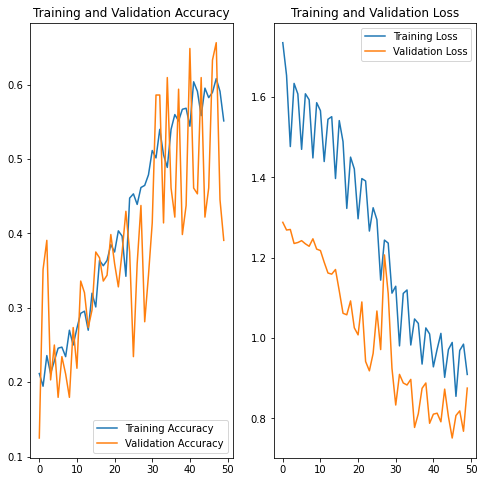

In [169]:
visualise_model_res(rnn_gru_5_hist, 50)

### Best model

In [32]:
convnet_2d_1_unit = make_2d_cnn_1_unit(input_shape[1:])
rnn_gru_1 = Sequential([
    TimeDistributed(convnet_2d_1_unit, input_shape = input_shape),
    
    GRU(64),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation = 'softmax')
])

In [33]:
rnn_gru_1.compile(optimizer=optim_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy',],)

In [39]:
rnn_gru_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 256)          980416    
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 64)                61824     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [40]:
setup_data_with_aug()

In [63]:
rnn_gru_1_hist = rnn_gru_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/50
11/11 [==============================] - 114s 11s/step - loss: 1.6814 - categorical_accuracy: 0.2017 - val_loss: 1.2579 - val_categorical_accuracy: 0.1641 - lr: 1.0000e-04
Epoch 2/50
11/11 [==============================] - 106s 11s/step - loss: 1.6211 - categorical_accuracy: 0.2344 - val_loss: 1.2647 - val_categorical_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 3/50
11/11 [==============================] - 98s 10s/step - loss: 1.4948 - categorical_accuracy: 0.2173 - val_loss: 1.2539 - val_categorical_accuracy: 0.3516 - lr: 1.0000e-04
Epoch 4/50
11/11 [==============================] - 104s 10s/step - loss: 1.6054 - categorical_accuracy: 0.2415 - val_loss: 1.2238 - val_categorical_accuracy: 0.2734 - lr: 1.0000e-04
Epoch 5/50
11/11 [==============================] - 106s 11s/step - loss: 1.5792 - categorical_accuracy: 0.2741 - val_loss: 1.2111 - val_categorical_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 6/50
11/11 [==============================] - 97s 10s/step - loss: 1.4595 - cate

In [ ]:
visualise_model_res(rnns_gru_1_hist, 32)

### The model converges around 30 epochs with ~80% accuracy

## End